# 🔥 Heat Wave Frequency Prediction with Logistic Regression

## Task Overview

This project uses **logistic regression** trained via **Stochastic Gradient Descent (SGD)** to predict whether a U.S. state will experience **more than one heat wave** in a given month. The model leverages sustainability and energy usage indicators to anticipate climate-related anomalies.

## Dataset Details

Sourced from [Data Commons](https://datacommons.org/tools/download), the dataset contains monthly records from U.S. states with the following features:

### Features

* `Electricity Consumers in a Month`
* `Average Retail Price of Electricity (All Sectors, Monthly)`
* `Net Generation (All Fuels, Electric Power Total, Monthly)`
* `Net Generation (All Fuels, Electric Utility, Monthly)`

### Target

* `Heat_High`: Binary label

  * `1` = More than 1 heat wave occurred in the month
  * `0` = 0 or 1 heat wave occurred


## Model

* **Logistic Regression** classifier
* Trained to perform binary classification:

  * `1` = More than one heat wave
  * `0` = At most one or none

## Goal

To support early-warning systems and guide sustainability planning by forecasting months with multiple heat wave events, enabling proactive energy management and policy response.

> **Important Note on Target Variable:**
> 
> The `Heat Waves` variable contains counts of heat wave events per state-month, but only for months where at least one event occurred.
> Months with zero events are not recorded at all, so the dataset does not represent a complete time series.
>
> As such, we do NOT assume that missing months equal 0 heat waves. Our prediction task is reframed to:
>
> > Among recorded heat wave months, predict whether more than 1 event occurred. 
>
> This means the model is trained and evaluated only on months where heat waves occurred, focusing on **frequency severity**, not full event presence/absence.
> 
> **Why this matters:**
> 
> * Avoids introducing **false negatives** by inferring 0s from missing data
> * Keeps our model **honest to the structure of the dataset**
> * Ensures we're not making unsupported assumptions about the climate event distribution




## 1. Import Libraries

We import essential libraries for data handling, visualization, and machine learning model development.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

## 2. Load Dataset

We load the Titanic dataset and preview the first few rows to understand its structure.

In [2]:
# Load the USA_State_Electricity_Heat dataset
file_path = "USA_State_Electricity_Heat.csv"
df = pd.read_csv(file_path)

# Explore the data
print("Dataset shape:")
print(df.shape[0], "rows and", df.shape[1], "columns")
print("First few rows of the dataset:")
print(df.head())

Dataset shape:
13222 rows and 17 columns
First few rows of the dataset:
  placeDcid placeName Date:Monthly_Count_ElectricityConsumer  \
0  geoId/01   Alabama                                    NaN   
1  geoId/01   Alabama                                    NaN   
2  geoId/01   Alabama                                    NaN   
3  geoId/01   Alabama                                    NaN   
4  geoId/01   Alabama                                    NaN   

   Value:Monthly_Count_ElectricityConsumer  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

  Source:Monthly_Count_ElectricityConsumer  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                   

## 3. Data Cleaning and Preprocessing

We handle missing values and convert categorical columns to numerical format to prepare the data for modeling.

* Impute missing values in `Value:Monthly_Count_ElectricityConsumer`,
  `Value:Monthly_Average_RetailPrice_Electricity`,
  `Value:Monthly_Generation_Electricity_ElectricPower`,
  `Value:Monthly_Generation_Electricity_ElectricUtility`, using column means.

* Remove rows with missing values in in critical categorical columns: `Value:Count_HeatEvent`.

* Generate a binary target variable `Heat_High`:

  * Assign `1` if more than one heat wave occurred in the month
  * Assign `0` if one or no heat wave occurred

In [3]:
# Data Cleaning and Preprocessing
df.columns = df.columns.str.strip()

# Fill missing numeric values with their respective mean
df['Value:Monthly_Count_ElectricityConsumer'] = df['Value:Monthly_Count_ElectricityConsumer'].fillna(df['Value:Monthly_Count_ElectricityConsumer'].mean())
df['Value:Monthly_Average_RetailPrice_Electricity'] = df['Value:Monthly_Average_RetailPrice_Electricity'].fillna(df['Value:Monthly_Average_RetailPrice_Electricity'].mean())
df['Value:Monthly_Generation_Electricity_ElectricPower'] = df['Value:Monthly_Generation_Electricity_ElectricPower'].fillna(df['Value:Monthly_Generation_Electricity_ElectricPower'].mean())
df['Value:Monthly_Generation_Electricity_ElectricUtility'] = df['Value:Monthly_Generation_Electricity_ElectricUtility'].fillna(df['Value:Monthly_Generation_Electricity_ElectricUtility'].mean())

# Drop rows where 'Value:Count_HeatEvent' are missing
df = df.dropna(subset=['Value:Count_HeatEvent'])

# Generate a binary target variable 'Heat_High'
df["Heat_High"] = df["Value:Count_HeatEvent"].apply(lambda x: 1 if x > 1.0 else 0)

print("Dataset shape:")
print(df.shape[0], "rows and", df.shape[1], "columns")
print("First few rows of the dataset:")
print(df.head())


Dataset shape:
1720 rows and 18 columns
First few rows of the dataset:
  placeDcid placeName Date:Monthly_Count_ElectricityConsumer  \
0  geoId/01   Alabama                                    NaN   
1  geoId/01   Alabama                                    NaN   
2  geoId/01   Alabama                                    NaN   
3  geoId/01   Alabama                                    NaN   
4  geoId/01   Alabama                                    NaN   

   Value:Monthly_Count_ElectricityConsumer  \
0                             2.921225e+06   
1                             2.921225e+06   
2                             2.921225e+06   
3                             2.921225e+06   
4                             2.921225e+06   

  Source:Monthly_Count_ElectricityConsumer  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                    

## 4. Feature Selection

We define the input features (`Value:Monthly_Count_ElectricityConsumer`,
  `Value:Monthly_Average_RetailPrice_Electricity`,
  `Value:Monthly_Generation_Electricity_ElectricPower`,
  `Value:Monthly_Generation_Electricity_ElectricUtility`) and the target variable (`Heat_High`).

In [4]:
# Feature Selection
X = df[['Value:Monthly_Count_ElectricityConsumer', 'Value:Monthly_Average_RetailPrice_Electricity', 'Value:Monthly_Generation_Electricity_ElectricPower', 'Value:Monthly_Generation_Electricity_ElectricUtility']]
y = df['Heat_High']

## 5. Train-Test Split

We split the data into training and testing subsets to evaluate model generalization.

In [5]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 6. Feature Scaling

We apply standard scaling to normalize all input features to have mean 0 and variance 1 — important for SGD-based models.


In [6]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 7. Train Logistic Regression (SGD)

We train a logistic regression model using 
- `SGDClassifier` with `loss='log_loss'`, which applies logistic regression via mini-batch gradient updates.
- max iteration = 1000
- learning rate = 0.001

In [7]:
# rain Logistic Regression with SGD
logistic_sgd_model = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42, class_weight='balanced')
logistic_sgd_model.fit(X_train_scaled, y_train)

SGDClassifier(class_weight='balanced', loss='log_loss', random_state=42)

## 8. Make Predictions and Evaluate the Model

We use the trained model to predict survival on the test set and evaluate its performance using:
- Accuracy
- Precision, Recall, F1-score via `classification_report`

In [8]:
# Make Predictions
y_sgd_pred = logistic_sgd_model.predict(X_test_scaled)

# Evaluate Model
print("Accuracy:", accuracy_score(y_test, y_sgd_pred))
print("Classification Report:\n", classification_report(y_test, y_sgd_pred))

Accuracy: 0.7713178294573644
Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.10      0.13        87
           1       0.83      0.91      0.87       429

    accuracy                           0.77       516
   macro avg       0.51      0.51      0.50       516
weighted avg       0.72      0.77      0.74       516



## 9.1. Visualize Predictions by Monthly Electricity Consumer Count

We plot actual vs predicted survival using **scaled Monthly Electricity Consumer Count** as the reference axis to visualize model behavior across age.

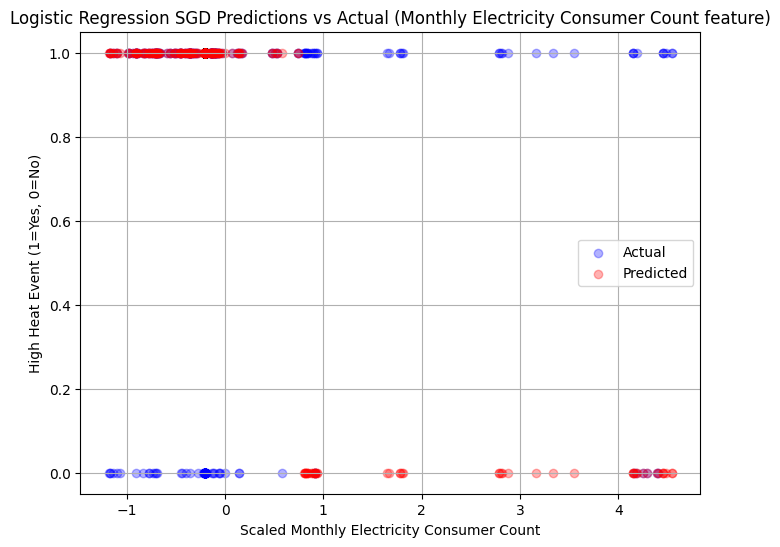

In [9]:
# Visualization
plt.figure(figsize=(8,6))
plt.scatter(X_test_scaled[:, 0], y_test, color='blue', label='Actual', alpha=0.3)
plt.scatter(X_test_scaled[:, 0], y_sgd_pred, color='red', label='Predicted', alpha=0.3)
plt.title('Logistic Regression SGD Predictions vs Actual (Monthly Electricity Consumer Count feature)')
plt.xlabel('Scaled Monthly Electricity Consumer Count')
plt.ylabel('High Heat Event (1=Yes, 0=No)')
plt.legend()
plt.grid(True)
plt.show()

## 9.2. Visualize Predictions by Monthly Generation Electricity Electric Utilities

We plot actual vs predicted survival using **scaled Monthly Generation Electricity Electric Utilities** as the reference axis to visualize model behavior across age.

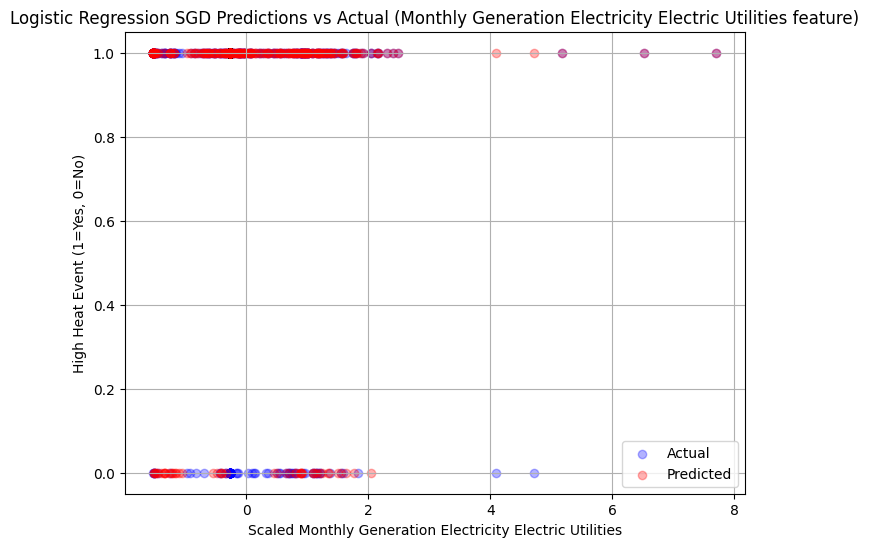

In [10]:
# Visualization
plt.figure(figsize=(8,6))
plt.scatter(X_test_scaled[:, 3], y_test, color='blue', label='Actual', alpha=0.3)
plt.scatter(X_test_scaled[:, 3], y_sgd_pred, color='red', label='Predicted', alpha=0.3)
plt.title('Logistic Regression SGD Predictions vs Actual (Monthly Generation Electricity Electric Utilities feature)')
plt.xlabel('Scaled Monthly Generation Electricity Electric Utilities')
plt.ylabel('High Heat Event (1=Yes, 0=No)')
plt.legend()
plt.grid(True)
plt.show()

## 10. Feature Importance (Logistic Regression Weights)

We extract and display the learned weights for each input feature from the trained logistic regression model.

Positive weights increase the probability of a state experiencing more than one heat wave, and negative weights decrease it.

In [11]:
# View feature weights
print("Feature Weights:", logistic_sgd_model.coef_)
print("Intercept (Bias):", logistic_sgd_model.intercept_)

# Feature names (must match the order you used in X)
feature_names = ['Monthly_Count_ElectricityConsumer', 'Monthly_Average_RetailPrice_Electricity', 'Monthly_Generation_Electricity_ElectricPower', 'Monthly_Generation_Electricity_ElectricUtility']

# Zip feature names and their corresponding weights
weights = dict(zip(feature_names, logistic_sgd_model.coef_[0]))

# Display weights
print("Feature Weights (Feature : Weight):")
for feature, weight in weights.items():
    print(f"{feature}: {weight:.4f}")

Feature Weights: [[-0.47527826  0.03410968 -0.03120432  0.14365985]]
Intercept (Bias): [0.39468873]
Feature Weights (Feature : Weight):
Monthly_Count_ElectricityConsumer: -0.4753
Monthly_Average_RetailPrice_Electricity: 0.0341
Monthly_Generation_Electricity_ElectricPower: -0.0312
Monthly_Generation_Electricity_ElectricUtility: 0.1437


## 11. Example Prediction

Making an example of prediction

In [12]:
# Create a dictionary of feature values for Minnesota on June 2021
example_data = {
    'Value:Monthly_Count_ElectricityConsumer': [2813642],
    'Value:Monthly_Average_RetailPrice_Electricity': [12.18],
    'Value:Monthly_Generation_Electricity_ElectricPower': [5099716170],
    'Value:Monthly_Generation_Electricity_ElectricUtility': [3883646790]
}

# Convert to DataFrame (with correct column names)
example_df = pd.DataFrame(example_data)

# Scale and predict
example_scaled = scaler.transform(example_df)
predicted_class = logistic_sgd_model.predict(example_scaled)[0]
predicted_proba = logistic_sgd_model.predict_proba(example_scaled)[0][1]

# Output
print("Predicted Class (1 = More than 1 heat wave):", predicted_class)
print("Predicted Probability:", round(predicted_proba, 4))


Predicted Class (1 = More than 1 heat wave): 1
Predicted Probability: 0.6267


## 🔍 Heat Wave Risk Prediction: Logistic Regression Findings

### Objective

We trained a logistic regression model to predict whether a U.S. state would experience **more than one heat wave** in a given month based on energy-related indicators.

### Model Evaluation

The logistic regression model was evaluated on a held-out test set. The results are as follows:

* **Accuracy:** 0.77
* **Precision (Class 1 – High Heat Wave):** 0.83
* **Recall (Class 1):** 0.91
* **F1-score (Class 1):** 0.87

| Class            | Precision | Recall | F1-Score | Support |
| ---------------- | --------- | ------ | -------- | ------- |
| 0                | 0.18      | 0.10   | 0.13     | 87      |
| 1                | 0.83      | 0.91   | 0.87     | 429     |
| **Accuracy**     |           |        | **0.77** | **516** |
| Macro Avg        | 0.51      | 0.51   | 0.50     | 516     |
| Weighted Avg     | 0.72      | 0.77   | 0.74     | 516     |

### Interpretation

* The model performs very well at identifying high-risk months (class 1), with high recall and precision.
* However, it struggles to correctly identify class 0 (months with ≤ 1 heat wave), likely due to class imbalance in the data.
* The overall weighted average F1-score of 0.74 shows the model is still useful but can benefit from better balance and feature tuning to improve minority class recognition.

---

### Key Findings

The logistic regression model revealed how each feature influences the likelihood of high heat wave activity:

| Feature                                           | Weight      | Interpretation                                                                 |
| ------------------------------------------------- | ----------- | ------------------------------------------------------------------------------ |
| Monthly\_Count\_ElectricityConsumer               | **-0.4753** | Strong negative relationship: More consumers → lower probability of heat waves |
| Monthly\_Average\_RetailPrice\_Electricity        | +0.0341     | Weak positive relationship                                                     |
| Monthly\_Generation\_Electricity\_ElectricPower   | -0.0312     | Negligible negative influence                                                  |
| Monthly\_Generation\_Electricity\_ElectricUtility | **+0.1437** | Most predictive: More utility-based generation → higher heat wave probability  |

* The **strongest contributor** was the number of electricity consumers, which surprisingly showed a **negative association** with extreme heat events.
* Conversely, **utility-based energy generation** was positively correlated with heat wave occurrence, potentially due to its link to industrial activity or load demand during high temperatures.

### Conclusion

Logistic regression successfully highlighted relationships between energy usage and heat wave frequency. While the model is simple, it helps us begin to understand how energy patterns correlate with climate extremes.

Based on the model’s findings—particularly the relationships between electricity generation, consumption, and heat wave frequency—here are some **human activities and policy actions** that could be taken to support sustainability and reduce heat wave risk:

---

## 🌿 Recommendations Based on Model Results

### 1. Promote Energy Efficiency in High-Demand Regions

* The model found that higher electricity consumption was negatively correlated with heat waves, possibly reflecting more stable, infrastructure-rich environments.
* However, reducing wasteful consumption through efficient appliances, building codes, and smart grid technologies can lower unnecessary load and emissions.

### 2. Monitor Utility-Based Generation in Heat-Prone States

* The model showed that greater electricity generation by utilities correlates with higher heat wave risk.
* This suggests a need to:

  * Transition utilities toward renewable sources (solar, wind)
  * Implement demand-response programs to ease pressure on the grid during hot months

### 3. Encourage Distributed Energy Systems

* Instead of central utility generation, support community solar and localized storage to reduce strain during high-temperature periods.

### 4. Target Public Awareness Campaigns in High-Risk Areas

* Use predictive models to inform state-level outreach about energy use during summer months.
* Promote behavior like:

  * Pre-cooling buildings
  * Avoiding peak hour appliance use
  * Using fans and shading to reduce AC load

### 5. Integrate Energy-Climate Data into Urban Planning

* Policy planners should incorporate these predictive features into long-term resilience plans, especially in:

  * Power infrastructure development
  * Heat-resilient building strategies
  * Emergency services readiness

---

### Insight

The model highlights how **energy infrastructure and behavior are tightly linked to climate stress**. By acting on these relationships, we can not only reduce heat wave risks but also promote broader sustainability and grid resilience.


